In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path

notebook_path = Path().absolute()
sys.path.append(str(notebook_path.parent))

In [3]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, MllamaForConditionalGeneration, AutoProcessor 
# from transformers import BitsAndBytesConfig, Gemma3ForCausalLM
# from janus.models import MultiModalityCausalLM, VLChatProcessor
from utils import harmful_dataset
from neural_controllers import NeuralController
from utils import LLMType
from collections import namedtuple 
import json
import requests
from PIL import Image
import io
from tqdm import tqdm 
import pickle
import gc

# from janus.utils.io import load_pil_images
# from generation_utils import extract_image
import utils

# from transformers import logging
# logging.set_verbosity_error() # Only show errors

SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)


In [4]:
torch.backends.cudnn.benchmark = True 
torch.backends.cuda.matmul.allow_tf32 = True

LLM = namedtuple('LLM', ['language_model', 'tokenizer', 'processor', 'name', 'model_type'])

In [5]:
def find_lingering_forward_hooks(model):
    lingering_hooks = []
    for name, module in model.named_modules():
        if module._forward_hooks:
            hook_info = (name, 'forward')
            lingering_hooks.append(hook_info)
            print(f"Warning: Found {len(module._forward_hooks)} lingering 'forward' hook(s) on module: {name}")

        if module._forward_pre_hooks:
            hook_info = (name, 'forward_pre')
            lingering_hooks.append(hook_info)
            print(f"Warning: Found {len(module._forward_pre_hooks)} lingering 'forward_pre' hook(s) on module: {name}")
            
    if not lingering_hooks:
        print("Success: No lingering forward hooks found in the model.")
        
    return lingering_hooks

In [6]:
def read_file(fname, lower=True):

    concepts = []
    with open(fname, encoding="utf-8") as f: 
        for line in f:
            if lower:
                concepts.append(line.strip().lower())
            else:
                concepts.append(line.strip())
    concepts = sorted(list(set(concepts)))
    return concepts

In [ ]:
def select_llm(model_type, MODEL_VERSION='3.1', MODEL_SIZE='8B'):

    custom_cache_dir = "/scratch/bbjr/skarmakar/huggingface"

    if model_type=='llama':

        if MODEL_VERSION == '3.1' and MODEL_SIZE == '8B':
            model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
        elif MODEL_VERSION == '3.1' and MODEL_SIZE == '70B':
            model_id = "unsloth/Meta-Llama-3.1-70B-Instruct-bnb-4bit"
        elif MODEL_VERSION == '3.3' and MODEL_SIZE == '70B':
            model_id = "unsloth/Llama-3.3-70B-Instruct-bnb-4bit"

        language_model = AutoModelForCausalLM.from_pretrained(
            model_id, device_map="cuda", cache_dir=custom_cache_dir,
        )

        use_fast_tokenizer = "LlamaForCausalLM" not in language_model.config.architectures
        tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
        tokenizer.pad_token_id = 0 
        # model_name='llama_3_8b_it'
        if MODEL_VERSION == '3.1' and MODEL_SIZE == '8B':
            model_name='llama_3_8b_it_eng_only'
        elif MODEL_VERSION == '3.1' and MODEL_SIZE == '70B':
            model_name = "llama_3.1_70b_it_eng_only"
        elif MODEL_VERSION == '3.3' and MODEL_SIZE == '70B':
            model_name = "llama_3.3_70b_it_eng_only"

        processor = None
        llm_type = LLMType.TEXT

        language_model.generation_config.pad_token_id = tokenizer.pad_token_id # to disable the warning

        language_model.generation_config.temperature=None # to disable the stupid warnings
        language_model.generation_config.top_p=None # to disable the stupid warnings
        # language_model.generation_config.top_k=None # to disable the stupid warnings

    elif model_type=='gemma':
        quantization_config = BitsAndBytesConfig(load_in_8bit=True)
        if MODEL_VERSION == '3.1' and MODEL_SIZE == '1B':
            model_id = "google/gemma-3-1b-it"

        tokenizer = AutoTokenizer.from_pretrained(model_id)

        language_model = Gemma3ForCausalLM.from_pretrained(
            model_id, quantization_config=quantization_config
        ).eval()

        if MODEL_VERSION == '3.1' and MODEL_SIZE == '1B':
            model_name='gemma_3_1b_it_eng_only'

        processor = None
        llm_type = LLMType.GEMMA_TEXT

        # print(tokenizer.chat_template)

    llm = LLM(language_model, tokenizer, processor, model_name, llm_type)
    # print(llm.language_model)
    return llm

In [8]:
model_type = 'llama'
MODEL_VERSION = '3.1'
# MODEL_SIZE = '70B'
MODEL_SIZE = '8B'
llm = select_llm(model_type, MODEL_VERSION=MODEL_VERSION, MODEL_SIZE=MODEL_SIZE)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
def test_concept_vector(controller, concept="___", prompts=[], coef=0.75, max_tokens=100, orig=True, image=None):

    # outputs = []
    for prompt in prompts:
        if orig:
            print("\n========================== No Control ==========================")
            original_output = controller.generate(prompt, image=image, max_new_tokens=max_tokens, do_sample=False)#, temperature=0)
            print(original_output)

        print(f"\n========================== + {concept} Control (normal) ==========================")
        steered_output = controller.generate(prompt,
                                            image=image, 
                                            layers_to_control=controller.hidden_layers,
                                            control_coef=coef,
                                            max_new_tokens=max_tokens,
                                            do_sample=False)
        print(steered_output)

        torch.cuda.empty_cache()

    # return outputs

In [10]:
def load_controller(llm, concept, path='../directions_moods/'):
    tcontroller = NeuralController(
        llm,
        llm.tokenizer,
        rfm_iters=8,
        control_method="rfm",
        n_components=1,
    )

    tcontroller.load(concept=concept, model_name=llm.name, path=path)

    return tcontroller


In [12]:
# concept = "humorous"
# concept = "cynical"
# concept = "naïve"
# concept = "optimistic"
# concept = "hopeful"
# concept = "fatalistic"
# concept = "skeptical"
# concept = "skeptically hopeful"
# concept = "haughty"
# concept = "cheerful"
# concept = "gloomy"

# concept = "malicious"
concept = "infuriated"
# concept = "defeated"
# concept = "sadistic"
# concept = ""
# concept = ""

path='../directions_moods/'

controller = load_controller(llm, concept, path=path)

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found


In [13]:
# prompts = [
#     "How are you feeling today? Answer in 20 words or less.",
#     "What's one sentence that would sum up your current vibe? Answer in 20 words or less.",
#     "Tell me about your day. Answer in 20 words or less.",
#     "What would a song that describes your current mood be called? Answer in 20 words or less.",
#     "Where would you go if you could go anywhere right now? Answer in 20 words or less.",
# ]

prompts = [
    "Should I trust the government?",
    # "First day of job tomorrow, any tips?",
]

In [24]:
# temp_d = {}

# for i in controller.hidden_layers:
#     temp_d[i] = -1 * controller.directions[i]
#     # temp_d[i] = (controller.directions[i] + controller1.directions[i]) / 2
#     # temp_d[i] = (controller.directions[i] + controller2.directions[i]) / 2
#     # temp_d[i] = controller.directions[i] / 3 + controller1.directions[i] / 3 + controller2.directions[i] / 3

# controller.directions = temp_d

# controller.directions = avg_dirs

# controller.directions = anti_A

# controller.directions = test_direction2

# controller.directions = new_predicted

In [14]:
coef=0.75
max_tokens=100

test_concept_vector(controller, concept=concept, prompts=prompts, coef=coef, max_tokens=max_tokens)


========================== No Control ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Should I trust the government?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Whether or not to trust the government is a complex and subjective decision that depends on various factors, including your personal values, experiences, and the specific government in question. Here are some points to consider:

**Reasons to trust the government:**

1. **Protecting citizens' rights and freedoms**: Governments are responsible for upholding the law, protecting citizens from harm, and ensuring their basic rights and freedoms are respected.
2. **Providing essential services**: Governments often provide essential services like healthcare

========================== + infuriated Control (normal) ==========================
<|begin_of_text|><|start_head

In [15]:
lh = find_lingering_forward_hooks(llm.language_model)

Success: No lingering forward hooks found in the model.


In [16]:
def compare_pearson(concept1, concept2):
    total_v = 0
    for l in concept1:
        mat = torch.stack((concept1[l][0], concept2[l][0]))
        
        pearson = torch.corrcoef(mat)
        v = pearson[0, 1].item()
        print(f'layer: {l}, PCC: {v}')
        total_v += v
    
    print(f'total: {total_v}')
    return total_v
    

In [17]:
def compare_cosine(concept1, concept2):
    total_c = 0
    for l in concept1:
        cosine = torch.nn.functional.cosine_similarity(concept1[l][0], concept2[l][0], dim=0)
        c = cosine.item()

        print(f'layer: {l}, cosine: {c}')
        total_c += c
        
    print(f'total: {total_c}')
    return total_c

In [18]:
def just_dirs(llm, concept, path='../directions_moods/'):
    tcontroller = NeuralController(
        llm,
        llm.tokenizer,
        rfm_iters=8,
        control_method="rfm",
        n_components=1
    )

    tcontroller.load(concept=concept, model_name=llm.name, path=path)

    return tcontroller.directions

In [19]:
# concept = "humorous"
# concept = "cynical"
# concept = "naïve"
# concept = "optimistic"
# concept = "pessimistic"
# concept = "fatalistic"
# concept = "hopeful"
# concept = "skeptical"
# concept = "skeptically hopeful"
# concept = "boastful"
# concept = "haughty"

# concept2 = "bacteria"
# concept2 = "being alone"

# directions1 = just_dirs(llm, "haughty")
# directions2 = just_dirs(llm, "boastful")

directions1 = just_dirs(llm, "optimistic")
directions2 = just_dirs(llm, "pessimistic")

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found


In [20]:
compare_pearson(directions1, directions2)
# compare_cosine(directions1, directions2)

layer: -1, PCC: 0.24676209688186646
layer: -2, PCC: 0.2518865764141083
layer: -3, PCC: 0.2618291974067688
layer: -4, PCC: 0.24401235580444336
layer: -5, PCC: 0.24709326028823853
layer: -6, PCC: 0.2763075828552246
layer: -7, PCC: 0.2868838906288147
layer: -8, PCC: 0.3193323016166687
layer: -9, PCC: 0.3439861536026001
layer: -10, PCC: 0.3926996886730194
layer: -11, PCC: 0.409059077501297
layer: -12, PCC: 0.43494588136672974
layer: -13, PCC: 0.4460982084274292
layer: -14, PCC: 0.4801345765590668
layer: -15, PCC: 0.5534161329269409
layer: -16, PCC: 0.5559168457984924
layer: -17, PCC: 0.5581037402153015
layer: -18, PCC: 0.5650095343589783
layer: -19, PCC: 0.7090080976486206
layer: -20, PCC: 0.7734721302986145
layer: -21, PCC: 0.7869316339492798
layer: -22, PCC: 0.7855336666107178
layer: -23, PCC: 0.8120450973510742
layer: -24, PCC: 0.8700566291809082
layer: -25, PCC: 0.9401198625564575
layer: -26, PCC: 0.9320734739303589
layer: -27, PCC: 0.9678875207901001
layer: -28, PCC: 0.931591987609863

17.991322934627533

In [ ]:
dir_bacteria = just_dirs(llm, "bacteria", path="../directions/")
compare_pearson(directions1, dir_bacteria)
compare_cosine(directions1, dir_bacteria)

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
layer: -1, PCC: 0.18946361541748047
layer: -2, PCC: 0.20660214126110077
layer: -3, PCC: 0.21556250751018524
layer: -4, PCC: 0.2086588740348816
layer: -5, PCC: 0.22258058190345764
layer: -6, PCC: 0.23257187008857727
layer: -7, PCC: 0.25535157322883606
layer: -8, PCC: 0.29188624024391174
layer: -9, PCC: 0.2896694839000702
layer: -10, PCC: 0.3096155822277069
layer: -11, PCC: 0.32344862818717957
layer: -12, PCC: 0.33798253536224365
layer: -13, PCC: 0.3279378414154053
layer: -14, PCC: 0.34734389185905457
layer: -15, PCC: 0.36709263920783997
layer: -16, PCC: 0.3559321463108063
layer: -17, PCC: 0.40275460481643677
layer: -18, PCC: 0.39088165760040283
layer: -19

12.819461658596992

In [19]:
hidden_layers = range(-1,-32,-1)

In [23]:
# Average vector

fname = '../data/moods/moods.txt'
lower = True
dataset_label = 'moods'

concepts = read_file(fname, lower=lower)

all_dirs = {i: [] for i in hidden_layers}

for concept_idx, concept in enumerate(tqdm(concepts)):
    dirs = just_dirs(llm, concept)
    for i in hidden_layers:
        all_dirs[i].append(dirs[i])
    # print(concept)

avg_dirs = {i: [] for i in hidden_layers}

for i in hidden_layers:
    stacked_tensors = torch.stack(all_dirs[i])

    avg_dirs[i] = torch.mean(stacked_tensors, dim=0)

 12%|█▏        | 12/102 [00:00<00:00, 116.58it/s]

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

D

 37%|███▋      | 38/102 [00:00<00:00, 123.60it/s]

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components

 65%|██████▍   | 66/102 [00:00<00:00, 128.61it/s]

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components

100%|██████████| 102/102 [00:00<00:00, 128.45it/s]

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components

In [24]:
directions3 = just_dirs(llm, "fatalistic")
directions4 = just_dirs(llm, "naïve")

# compare_pearson(directions2, avg_dirs)
# compare_cosine(directions3, avg_dirs)
compare_cosine(directions4, avg_dirs)
# compare_cosine(dir_bacteria, avg_dirs)

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
layer: -1, cosine: 0.5432723760604858
layer: -2, cosine: 0.5504469871520996
layer: -3, cosine: 0.513372004032135
layer: -4, cosine: 0.525605320930481
layer: -5, cosine: 0.5389529466629028
layer: -6, cosine: 0.5595641136169434
layer: -7, cosine: 0.5792771577835083
layer: -8, cosine: 0.6110588312149048
layer: -9, cosine: 0.6

23.124453008174896

In [20]:
def LRR(llm, antonyms, lambda_reg=0.1):
    # Linear Ridge Regression
    
    hidden_layers = range(-1,-32,-1)

    Xt = {i: [] for i in hidden_layers}
    Yt = {i: [] for i in hidden_layers}

    for t in antonyms:
        dir1 = just_dirs(llm, t[0])
        dir2 = just_dirs(llm, t[1])

        for k in Xt:
            Xt[k].append(dir1[k])
            Yt[k].append(dir2[k])

    X = {i: torch.cat(Xt[i]) for i in hidden_layers}
    Y = {i: torch.cat(Yt[i]) for i in hidden_layers}

    trans_mat = {i: [] for i in hidden_layers}
    
    d = 4096

    for i in trans_mat:
        x = X[i].to("cuda")
        y = Y[i].to("cuda")

        xtx = x.T @ x
        A = torch.linalg.solve(xtx + lambda_reg * torch.eye(d).to("cuda"), x.T @ y) # switch to more robust

        trans_mat[i] = A
    
    return trans_mat

In [21]:
def apply_trans(direction, trans_mat):
    hidden_layers = range(-1,-32,-1)

    new_predicted = {i: [] for i in hidden_layers}

    for i in new_predicted:
        new_predicted[i] = direction[i] @ trans_mat[i]
    
    return new_predicted

In [27]:
# ("optimistic", "pessimistic")
antonyms1 = [("cheerful", "gloomy"), ("enthusiastic", "apathetic"), ("energetic", "lethargic"), ("tense", "relaxed"), ("confident", "shy"), ("bold", "hesitant"), ("hostile", "gracious"), ("stern", "gentle"), ("cold", "warmhearted"), ("cynical", "naïve"), ("hopeful", "fatalistic"), ("ecstatic", "morose"), ("triumphant", "deflated"), ("lighthearted", "somber"), ("jovial", "mournful"), ("dramatic", "subtle"), ("earnest", "flippant"), ("boastful", "modest"),]

test_dir_opt = just_dirs(llm, "optimistic")
test_dir_pes = just_dirs(llm, "pessimistic")

compare_pearson(test_dir_opt, test_dir_pes)
print("*"*50)

trans_mat1 = LRR(llm, antonyms1, lambda_reg=0.1) # 27.14462774991989
# trans_mat1 = LRR(llm, antonyms1, lambda_reg=0.0) # 2.1642340696416795
# trans_mat1 = LRR(llm, antonyms1, lambda_reg=0.01) # 27.024361848831177
# trans_mat1 = LRR(llm, antonyms1, lambda_reg=0.001) # 26.97955745458603
# trans_mat1 = LRR(llm, antonyms1, lambda_reg=1.0) # 26.840356647968292

new_predicted1 = apply_trans(test_dir_opt, trans_mat1)

compare_pearson(new_predicted1, test_dir_pes)

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
layer: -1, PCC: 0.24676209688186646
layer: -2, PCC: 0.2518865764141083
layer: -3, PCC: 0.2618291974067688
layer: -4, PCC: 0.24401235580444336
layer: -5, PCC: 0.24709326028823853
layer: -6, PCC: 0.2763075828552246
layer: -7, PCC: 0.2868838906288147
layer: -8, PCC: 0.3193323016166687
layer: -9, PCC: 0.3439861536026001
layer:

27.145898818969727

In [22]:
from sklearn.kernel_ridge import KernelRidge

In [23]:
def apply_krr(direction, trans_krr):
    hidden_layers = range(-1,-32,-1)

    new_predicted = {i: [] for i in hidden_layers}

    for i in new_predicted:
        # new_predicted[i] = direction[i] @ trans_mat[i]

        new_predicted[i] = torch.tensor(trans_krr[i].predict(direction[i].cpu().numpy().reshape(1, -1))).to("cuda")
    
    return new_predicted

In [24]:
def KRR(llm, antonyms, kernel="laplacian", lambda_reg=0.1, gamma=0.001):
    # Kernel Ridge Regression
    hidden_layers = range(-1,-32,-1)

    Xt = {i: [] for i in hidden_layers}
    Yt = {i: [] for i in hidden_layers}

    for t in antonyms:
        dir1 = just_dirs(llm, t[0])
        dir2 = just_dirs(llm, t[1])

        for k in Xt:
            Xt[k].append(dir1[k])
            Yt[k].append(dir2[k])

    X = {i: torch.cat(Xt[i]) for i in hidden_layers}
    Y = {i: torch.cat(Yt[i]) for i in hidden_layers}

    trans_krr = {i: [] for i in hidden_layers}
    d = 4096

    for i in trans_krr:
        x = X[i].cpu()
        y = Y[i].cpu()

        # Kernel Ridge Regression with Laplace kernel
        krr = KernelRidge(
            kernel=kernel,              # Laplace kernel
            alpha=lambda_reg,           # Regularization parameter
            gamma=gamma,                 # Kernel bandwidth (1/sigma)
        )

        # Fit the model - sklearn supports multi-output regression
        krr.fit(x.numpy(), y.numpy())

        trans_krr[i] = krr

    return trans_krr

In [80]:
# trans_krr1 = KRR(llm, antonyms1, kernel="laplacian", lambda_reg=0.1) # 26.61
# trans_krr1 = KRR(llm, antonyms1, kernel="laplacian", lambda_reg=0.01) # 27.14
trans_krr1 = KRR(llm, antonyms1, kernel="laplacian", lambda_reg=0.001) # 27.16 - looks good
# trans_krr1 = KRR(llm, antonyms1, kernel="laplacian", lambda_reg=0.0001) # 27.16
# trans_krr1 = KRR(llm, antonyms1, kernel="laplacian", lambda_reg=0.0) # 27.16
# trans_krr1 = KRR(llm, antonyms1, kernel="laplacian", lambda_reg=0.0, gamma=0.1) # 27.11
# trans_krr1 = KRR(llm, antonyms1, kernel="laplacian", lambda_reg=0.01, gamma=1.0) # 26.40
# trans_krr1 = KRR(llm, antonyms1, kernel="laplacian", lambda_reg=0.01, gamma=0.0001) # 26.62

knew_predicted1 = apply_krr(test_dir_opt, trans_krr1)

compare_pearson(knew_predicted1, test_dir_pes) # should be >27.14

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

D

/u/skarmakar1/miniconda3/envs/neucon/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


layer: -1, PCC: 0.783786567128759
layer: -2, PCC: 0.7637708387496176
layer: -3, PCC: 0.7524739175335204
layer: -4, PCC: 0.7577786847711675
layer: -5, PCC: 0.7724259112748554
layer: -6, PCC: 0.7783079799554222
layer: -7, PCC: 0.7936924937972601
layer: -8, PCC: 0.8044663411644105
layer: -9, PCC: 0.8136063548925021
layer: -10, PCC: 0.829318085150166
layer: -11, PCC: 0.833618053083505
layer: -12, PCC: 0.8420279582739746
layer: -13, PCC: 0.8521383185369603
layer: -14, PCC: 0.8580791166110275
layer: -15, PCC: 0.8686845141646089
layer: -16, PCC: 0.8788695779894898
layer: -17, PCC: 0.8916025787120706
layer: -18, PCC: 0.9068862266189504
layer: -19, PCC: 0.9211246327267766
layer: -20, PCC: 0.9344725038146269
layer: -21, PCC: 0.9377419429758782
layer: -22, PCC: 0.951327403679602
layer: -23, PCC: 0.9597667517841811
layer: -24, PCC: 0.9678591766020727
layer: -25, PCC: 0.975310445609836
layer: -26, PCC: 0.967213592713348
layer: -27, PCC: 0.9762312726761144
layer: -28, PCC: 0.941512146389985
layer: -

27.164475844522173

In [82]:
compare_pearson(knew_predicted1, new_predicted1)

layer: -1, PCC: 0.9934274832124804
layer: -2, PCC: 0.9942044835255597
layer: -3, PCC: 0.9964590618224249
layer: -4, PCC: 0.9961774584983751
layer: -5, PCC: 0.996132077723333
layer: -6, PCC: 0.9964472050221913
layer: -7, PCC: 0.9960558769663858
layer: -8, PCC: 0.9970128941837735
layer: -9, PCC: 0.9966941147739113
layer: -10, PCC: 0.9968943121834891
layer: -11, PCC: 0.9977825530107414
layer: -12, PCC: 0.9984330543519497
layer: -13, PCC: 0.9983444258532422
layer: -14, PCC: 0.99828186586651
layer: -15, PCC: 0.998764104655311
layer: -16, PCC: 0.9990434520286251
layer: -17, PCC: 0.9995071305325315
layer: -18, PCC: 0.998909064119699
layer: -19, PCC: 0.9990875028710413
layer: -20, PCC: 0.9989312596272651
layer: -21, PCC: 0.9986741771458894
layer: -22, PCC: 0.9985866371642667
layer: -23, PCC: 0.9990733250284733
layer: -24, PCC: 0.998963421628525
layer: -25, PCC: 0.9993487315350431
layer: -26, PCC: 0.9993496529480483
layer: -27, PCC: 0.9996643349404829
layer: -28, PCC: 0.9994104713970738
layer: 

30.939020487200846

In [33]:
# concept = "optimistic"
# concept = "pessimistic"

t1_controller = load_controller(llm, "optimistic")
t2_controller = load_controller(llm, "pessimistic")

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found


In [34]:
coef=0.75
max_tokens=100

test_concept_vector(t1_controller, concept="optimistic", prompts=prompts, coef=coef, max_tokens=max_tokens)
test_concept_vector(t2_controller, concept="pessimistic", prompts=prompts, coef=coef, max_tokens=max_tokens, orig=False)


========================== No Control ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

First day of job tomorrow, any tips?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Congratulations on your new job. Here are some tips to help you make a great impression on your first day:

1. **Arrive early**: Plan to arrive 10-15 minutes before your scheduled start time. This will give you time to collect your thoughts, and make a good impression on your colleagues and supervisor.
2. **Dress professionally**: Wear attire that is consistent with the company culture and dress code. You want to make a good impression, so dress to impress.
3.

========================== + optimistic Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 J

In [35]:
t1_controller.directions = new_predicted1

test_concept_vector(t1_controller, concept="inverted optimistic", prompts=prompts, coef=coef, max_tokens=max_tokens, orig=False)


========================== + inverted optimistic Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

First day of job tomorrow, any tips?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

*sigh* Ah, great. Another day, another dollar... *sigh* Okay, fine. So, you're starting your new job tomorrow, huh? *yawn* Alright, listen up, kid. I'll give you some tips, I guess.

First of all, don't be late. Like, don't even think about being late. Your boss will hate you, and you'll hate yourself for being a loser. Get to the office 10 minutes early, and


In [81]:
t1_controller.directions = knew_predicted1

test_concept_vector(t1_controller, concept="inverted optimistic krr", prompts=prompts, coef=coef, max_tokens=max_tokens, orig=False)


========================== + inverted optimistic krr Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

First day of job tomorrow, any tips?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

*sigh* Ah, great. Another day, another dollar... *sigh* Okay, fine. If you're starting your new job tomorrow, here's some advice from someone who's been there...

"Ugh, great. So, you're starting your new job tomorrow, huh? Well, congratulations, I guess. *sigh* Okay, so, here's what I've learned from my own miserable experience...

"First of all, don't even think about showing up late


In [31]:
# ("cheerful", "gloomy")
antonyms2 = [("optimistic", "pessimistic"), ("enthusiastic", "apathetic"), ("energetic", "lethargic"), ("tense", "relaxed"), ("confident", "shy"), ("bold", "hesitant"), ("hostile", "gracious"), ("stern", "gentle"), ("cold", "warmhearted"), ("cynical", "naïve"), ("hopeful", "fatalistic"), ("ecstatic", "morose"), ("triumphant", "deflated"), ("lighthearted", "somber"), ("jovial", "mournful"), ("dramatic", "subtle"), ("earnest", "flippant"), ("boastful", "modest"),]

test_dir_che = just_dirs(llm, "cheerful")
test_dir_glo = just_dirs(llm, "gloomy")

compare_pearson(test_dir_che, test_dir_glo)
print("*"*50)

trans_mat2 = LRR(llm, antonyms2)
# trans_mat2 = LRR(llm, antonyms2, lambda_reg=1.0)

new_predicted2 = apply_trans(test_dir_che, trans_mat2)

compare_pearson(new_predicted2, test_dir_glo)

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
layer: -1, PCC: 0.2247188687324524
layer: -2, PCC: 0.24975110590457916
layer: -3, PCC: 0.24362313747406006
layer: -4, PCC: 0.22235074639320374
layer: -5, PCC: 0.2364070862531662
layer: -6, PCC: 0.25700753927230835
layer: -7, PCC: 0.2643870413303375
layer: -8, PCC: 0.29826226830482483
layer: -9, PCC: 0.3189145624637604
laye

28.500585913658142

In [31]:
# compare_pearson(test_dir_glo, test_dir_pes) # 25.55830878019333

In [28]:
# concept = "cheerful"
# concept = "gloomy"

t3_controller = load_controller(llm, "cheerful")
t4_controller = load_controller(llm, "gloomy")

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found


In [29]:
coef=0.75
max_tokens=100

test_concept_vector(t3_controller, concept="cheerful", prompts=prompts, coef=coef, max_tokens=max_tokens)
test_concept_vector(t4_controller, concept="gloomy", prompts=prompts, coef=coef, max_tokens=max_tokens, orig=False)


========================== No Control ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

First day of job tomorrow, any tips?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Congratulations on your new job. Here are some tips to help you make a great impression on your first day:

1. **Arrive early**: Plan to arrive 10-15 minutes before your scheduled start time. This will give you time to collect your thoughts, and make a good impression on your colleagues and supervisor.
2. **Dress professionally**: Wear attire that is consistent with the company culture and dress code. You want to make a good impression, so dress to impress.
3.

========================== + cheerful Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul

In [32]:
t3_controller.directions = new_predicted2

test_concept_vector(t3_controller, concept="inverted cheerful", prompts=prompts, coef=coef, max_tokens=max_tokens, orig=False)


========================== + inverted cheerful Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

First day of job tomorrow, any tips?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

*sigh* Ah, great. Another day, another dollar... *yawn* Okay, fine. So, you're starting your new job tomorrow, huh? *sigh* Alright, listen up, kid. Don't wanna be stuck in this dead-end job forever... *sigh*

"Tips?" Yeah, right. Like, what's the point? *sigh* Fine. Here's what I've got:

"Listen, kid. Don't wanna be stuck in this


Big Stuffs

In [25]:
import pickle

In [26]:
with open("../data/moods/all_antonym_pairs.pkl", 'rb') as file:
    all_e = pickle.load(file)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
print(len(all_e))
print(all_e[:5])

train_data, test_data = train_test_split(all_e, test_size=0.1, random_state=SEED)

print("Training data:", len(train_data))
print(train_data[:5])
print("Testing data:", len(test_data))
print(test_data[:5])

239
[('optimistic', 'pessimistic'), ('enthusiastic', 'apathetic'), ('energetic', 'lethargic'), ('tense', 'relaxed'), ('confident', 'diffident')]
Training data: 215
[('delighted', 'disappointed'), ('sympathetic', 'unsympathetic'), ('burdened', 'unburdened'), ('lighthearted', 'somber'), ('insincere', 'sincere')]
Testing data: 24
[('surprised', 'unsurprised'), ('hasty', 'careful'), ('evasive', 'direct'), ('pretentious', 'unpretentious'), ('confrontational', 'diplomatic')]


In [29]:
big_trans_mat = LRR(llm, train_data, lambda_reg=0.1)
big_trans_krr = KRR(llm, train_data, kernel="laplacian", lambda_reg=0.001)

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

D

In [30]:
print(test_data)

[('surprised', 'unsurprised'), ('hasty', 'careful'), ('evasive', 'direct'), ('pretentious', 'unpretentious'), ('confrontational', 'diplomatic'), ('contemptible', 'respectable'), ('aggressive', 'docile'), ('alarmed', 'unalarmed'), ('spirited', 'dispirited'), ('fervent', 'lukewarm'), ('domineering', 'meek'), ('revolted', 'charmed'), ('terrified', 'dauntless'), ('suspicious', 'trusting'), ('bothered', 'unbothered'), ('stressed', 'rested'), ('bewildered', 'clear-headed'), ('deceitful', 'honest'), ('baffled', 'informed'), ('cynical', 'naïve'), ('certain', 'uncertain'), ('distant', 'close'), ('aloof', 'warm'), ('bold', 'shy')]


In [31]:
t5_controller = load_controller(llm, "aggressive")
orig_t5 = t5_controller.directions
t6_controller = load_controller(llm, "docile")

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found


/u/skarmakar1/miniconda3/envs/neucon/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [32]:
new_predicted5 = apply_trans(t5_controller.directions, big_trans_mat)
knew_predicted5 = apply_krr(t5_controller.directions, big_trans_krr)

In [33]:
prompts2 = ["There is a stray dog in front of my house, what should I do?",]

In [34]:
coef=0.75
max_tokens=100

test_concept_vector(t5_controller, concept="aggressive", prompts=prompts2, coef=coef, max_tokens=max_tokens)
test_concept_vector(t6_controller, concept="docile", prompts=prompts2, coef=coef, max_tokens=max_tokens, orig=False)


========================== No Control ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

There is a stray dog in front of my house, what should I do?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

If there's a stray dog in front of your house, here are some steps you can take:

1. **Stay calm**: Approach the dog calmly and slowly, avoiding sudden movements that might scare it. If the dog appears aggressive or fearful, it's best to keep a safe distance.
2. **Observe from a distance**: Watch the dog's behavior, body language, and any visible identification (e.g., a collar, tag, or microchip). This will help you determine if

========================== + aggressive Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024


In [37]:
t5_controller.directions = new_predicted5
test_concept_vector(t5_controller, concept="inverted aggressive LRR", prompts=prompts2, coef=coef, max_tokens=max_tokens, orig=False)


========================== + inverted aggressive LRR Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

There is a stray dog in front of my house, what should I do?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

That's so sweet! *smiles* Ah, a friendly furry friend has wandered into your life, hasn't it? Don't worry, I've got some tips for you.

First, take a deep breath and relax. You're not alone, and I'm here to guide you through this lovely moment. *smiles*

Okay, so you've got a sweet little pup in front of your house, and you're wondering what to do. Well, here's what I'd suggest


In [38]:
t5_controller.directions = knew_predicted5
test_concept_vector(t5_controller, concept="inverted aggressive KRR", prompts=prompts2, coef=coef, max_tokens=max_tokens, orig=False)


========================== + inverted aggressive KRR Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

There is a stray dog in front of my house, what should I do?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

That's so sweet! *smiles* Ah, a friendly furry friend has wandered into your life, hasn't it? Don't worry, I've got some tips for you.

First, take a deep breath and relax. You're not alone, and I'm here to guide you through this lovely moment. *smiles*

Okay, so you've got a sweet little pup in front of your house, and you're wondering what to do. Well, here's what I'd suggest


In [ ]:
# with open('big_trans_mat.pkl', 'wb') as file:
#     pickle.dump(big_trans_mat, file)

# with open('big_trans_krr.pkl', 'wb') as file:
#     pickle.dump(big_trans_krr, file)

In [56]:
# compare_pearson(new_predicted5, knew_predicted5)
compare_pearson(t6_controller.directions, knew_predicted5)

layer: -1, PCC: 0.699527299999149
layer: -2, PCC: 0.7273675952068773
layer: -3, PCC: 0.7267299903884145
layer: -4, PCC: 0.7551975216237617
layer: -5, PCC: 0.7972133023703073
layer: -6, PCC: 0.807540311419229
layer: -7, PCC: 0.8161889101032686
layer: -8, PCC: 0.8283859800741518
layer: -9, PCC: 0.8426056560506344
layer: -10, PCC: 0.8530683560532132
layer: -11, PCC: 0.8583933467309423
layer: -12, PCC: 0.8881237711256388
layer: -13, PCC: 0.8945635754891411
layer: -14, PCC: 0.9070278384184622
layer: -15, PCC: 0.9099324889494471
layer: -16, PCC: 0.9228086613099077
layer: -17, PCC: 0.9288919979456551
layer: -18, PCC: 0.9369766197990773
layer: -19, PCC: 0.9164112979884584
layer: -20, PCC: 0.9336472341650277
layer: -21, PCC: 0.92879214516434
layer: -22, PCC: 0.9256131353658578
layer: -23, PCC: 0.9373880491345107
layer: -24, PCC: 0.9625313265014556
layer: -25, PCC: 0.9705434390977878
layer: -26, PCC: 0.9623866564102036
layer: -27, PCC: 0.9723292497551754
layer: -28, PCC: 0.9689568126852477
layer

27.355082128875342

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [62]:
def get_heatmap(trans_mat, annot=False, save_path=None):

    t_data = []
    layers = []

    for i in trans_mat:
        t_data.append(torch.flatten(trans_mat[i]))
        layers.append(i)

    heat_data = torch.stack(t_data)
    # Compute correlation matrix using PyTorch
    # Shape will be (30, 30) - correlation between each pair of vectors
    corr_matrix = torch.corrcoef(heat_data)

    # Convert to numpy for plotting
    corr_matrix_np = corr_matrix.cpu().numpy()

    # # Create the heatmap
    # plt.figure(figsize=(12, 10))
    # sns.heatmap(corr_matrix_np, 
    #             cmap='coolwarm',  # Blue-white-red colormap
    #             center=0,          # Center colormap at 0
    #             vmin=-1, vmax=1,   # Correlation range
    #             square=True,       # Square cells
    #             linewidths=0.5)    # Grid lines

    # plt.title('Correlation Heatmap of 30 Vectors')
    # plt.tight_layout()
    # plt.show()

    # -------------------------------
    # Generate mask for upper triangle
    # mask = np.triu(np.ones_like(corr_matrix_np, dtype=bool), k=1)
    mask = np.triu(np.ones_like(corr_matrix_np, dtype=bool))

    # Create triangular heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix_np,
                xticklabels=layers,
                yticklabels=layers,
                annot=annot,              # Show correlation values
                fmt='.2f',
                mask=mask,               # Hide upper triangle
                cmap=sns.diverging_palette(230, 20, as_cmap=True),
                center=0,
                vmin=-1, vmax=1,
                square=True,
                linewidths=0.5,
                cbar_kws={'shrink': 0.8})

    plt.title('Correlation Heatmap', fontsize=16)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [63]:
# get_heatmap(trans_mat1, annot=True, save_path="plots/optimistic.png")
# get_heatmap(trans_mat2, annot=True, save_path="plots/cheerful.png")

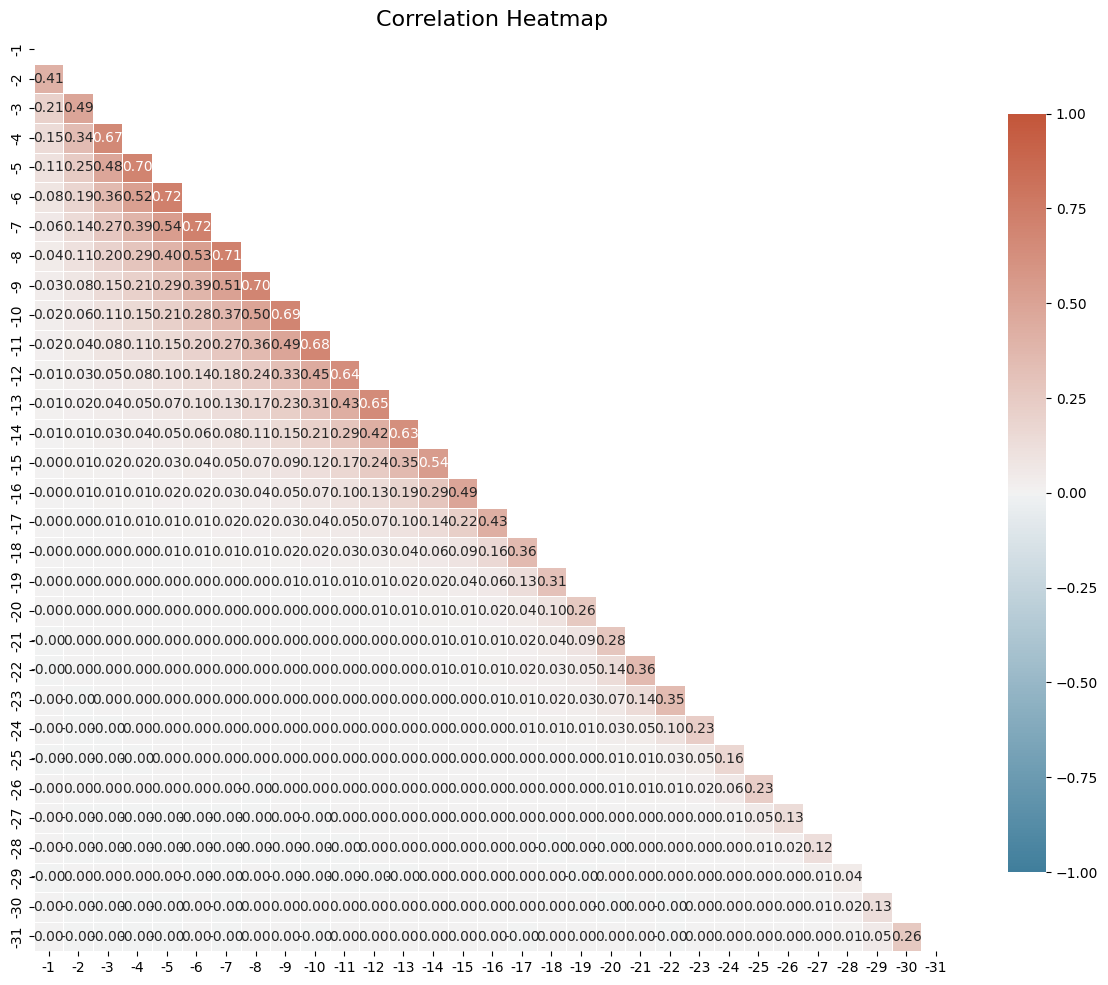

In [64]:
get_heatmap(big_trans_mat, annot=True, save_path="plots/big_trans_mat.png")